In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import tiramisu
from src.utils import history_to_results

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models

In [3]:
_ = camvid.create_segmented_y()

##### Note

Because of the skip connections between the down-sampling and up-sampling sides of the network, input image size must be divisible by 32 (2^5). This is because of the max pooling / transpose convolution layers on the down-sampling and up-sampling branch of the network respectively. There are 5 of these units each with 2x2 kernel size and stride 2. Thus, the input must be divisible by 2^5 to ensure the outputs along the down-sampling side of the net can concatenate with the up-sampling side.

In [4]:
# the size of the images in the dataset
target_size = (720, 960)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the size to crop images to for fine tune training
fine_crop = (512, 640)
# fine_crop = (480, 640)

# Coarse Tuning

train on random crops of size 224 x 224 (images are also random flipped about x and y axis)

In [5]:
camvid32 = camvid.CamVid('y_32', crop_size=coarse_crop)
generators = camvid32.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


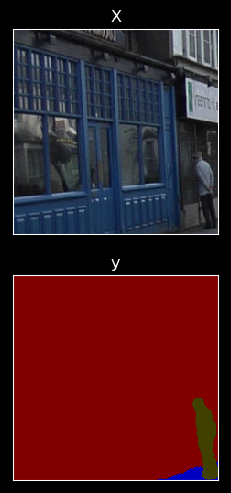

In [6]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid32.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [7]:
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), camvid32.n,
    label_names=camvid32.discrete_to_label_map,
    learning_rate=1e-3,
)

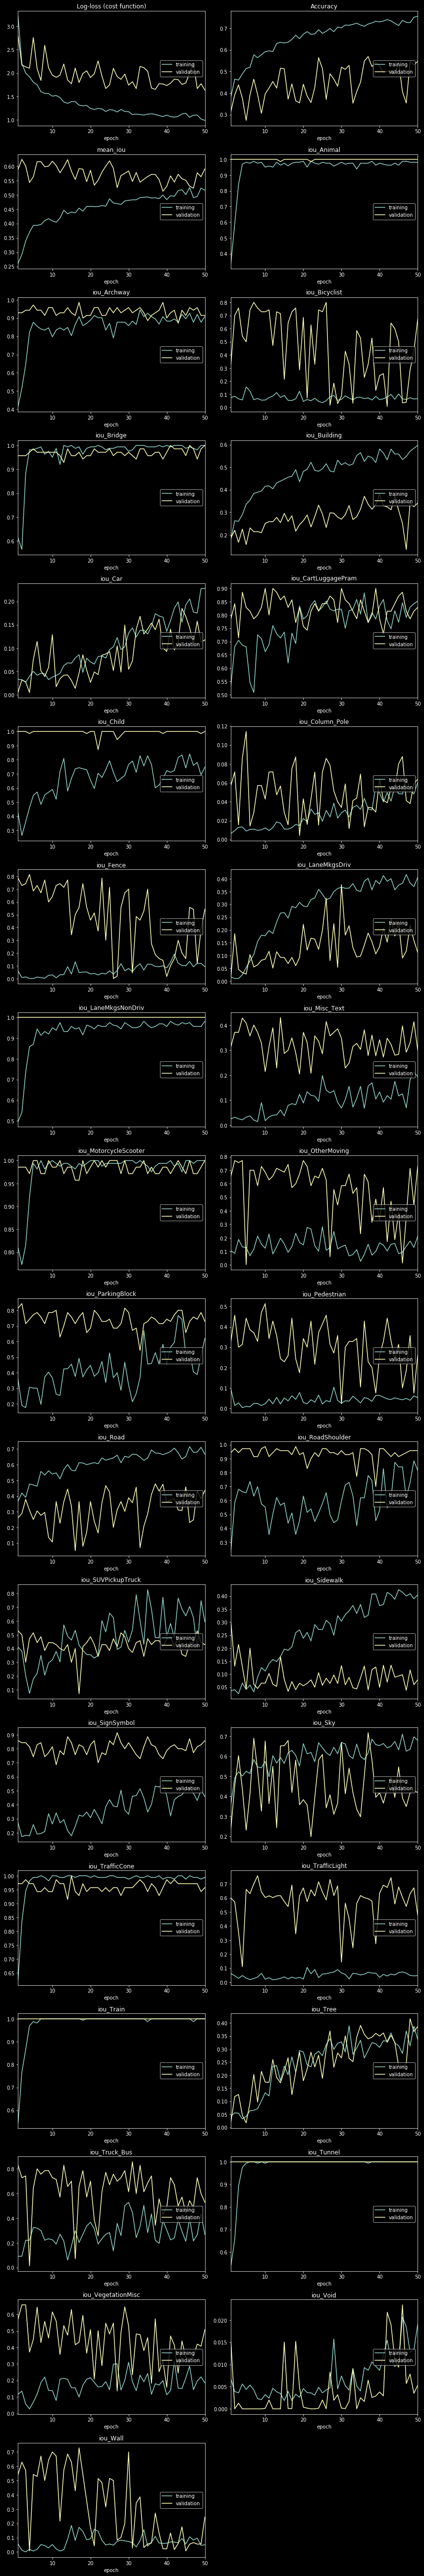

In [8]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=int(491 / 3),
    validation_data=generators['validation'],
    validation_steps=int(210 / 3),
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=100),
        PlotLossesKeras(),
    ],
    verbose=0
)

In [9]:
history_to_results(history)

,train,val
acc,0.754889,0.546092
Animal,0.981557,1.000000
Archway,0.907787,0.914286
Bicyclist,0.066886,0.671429
Bridge,1.000000,1.000000
Building,0.596484,0.340868
Car,0.227916,0.117500
CartLuggagePram,0.852459,0.828571
Child,0.747962,1.000000
Column_Pole,0.060437,0.063701


In [10]:
metrics = model.evaluate_generator(generators['validation'], steps=210)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

,val
loss,1.656930
acc,0.552723
mean_iou,0.579363
iou_Animal,1.000000
iou_Archway,0.923810
iou_Bicyclist,0.671429
iou_Bridge,0.952381
iou_Building,0.369012
iou_Car,0.094553
iou_CartLuggagePram,0.795238


In [11]:
X, y = next(generators['training'])
y = camvid32.unmap(y)
p = model.predict(X)
p = camvid32.unmap(p)

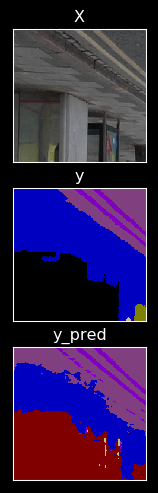

In [12]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

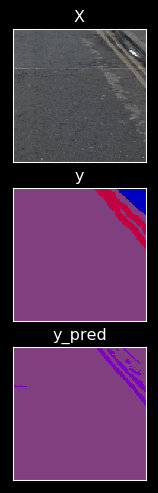

In [13]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

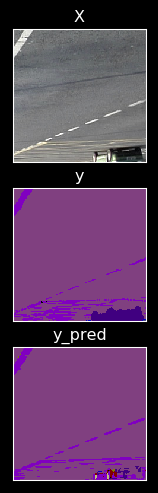

In [14]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

In [15]:
X, y = next(generators['validation'])
y = camvid32.unmap(y)
p = model.predict(X)
p = camvid32.unmap(p)

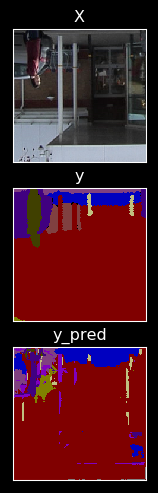

In [16]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

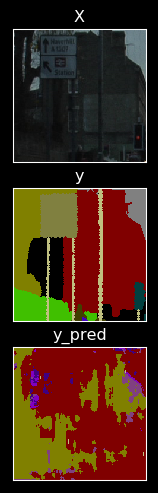

In [17]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

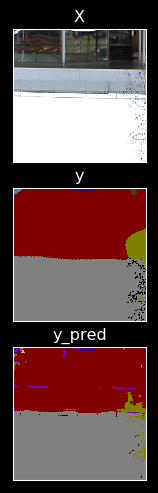

In [18]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

## Save Model

In [19]:
# serialize weights to HDF5
model.save_weights('models/Tiramisu103-CamVid32-coarse.h5')

# Clear Session

remove the current model from memory.

In [20]:
from keras import backend as K
K.clear_session()

# Fine Tuning

Train on larger crops (because the full size image results in a OutOfMemory error on the P100). max queue size of the fit generator is also reduced (resulting in a slowdown) to accomodate these larger images.

In [21]:
camvid32 = camvid.CamVid('y_32', crop_size=fine_crop, batch_size=1)
generators = camvid32.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


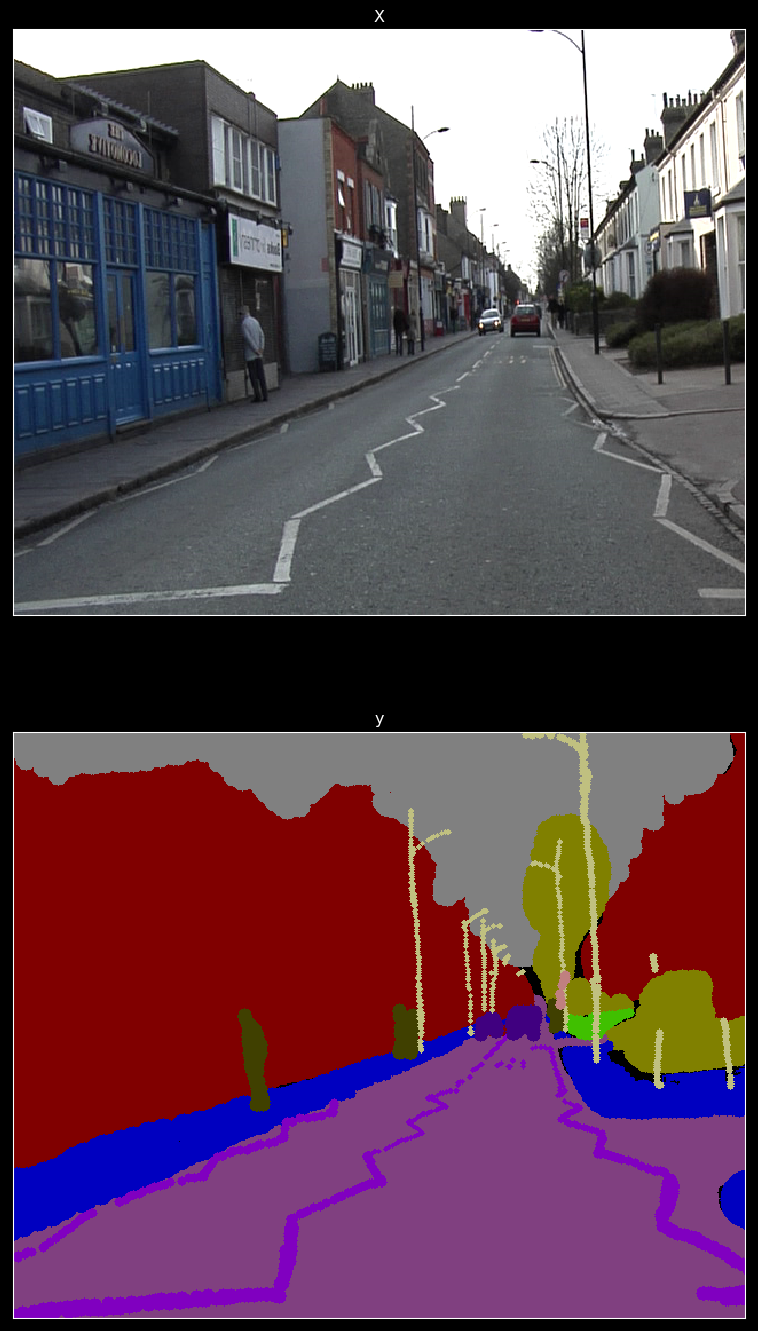

In [22]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid32.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [ ]:
# build the model for the image shape and number of labels
tune_model = tiramisu.build_tiramisu((*fine_crop, 3), camvid32.n,
    label_names=camvid32.discrete_to_label_map,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights('./models/Tiramisu103-CamVid32-coarse.h5')

In [ ]:
# fit the model with the data. use a small max queue size to 
# prevent an OOM error due to large image size
history = tune_model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=491,
    validation_data=generators['validation'],
    validation_steps=210,
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=50),
        PlotLossesKeras(),
    ],
    verbose=0,
    max_queue_size=1
)

In [ ]:
history_to_results(history)

In [ ]:
metrics = tune_model.evaluate_generator(generators['validation'], steps=210)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

In [ ]:
X, y = next(generators['training'])
y = camvid32.unmap(y)
p = tune_model.predict(X)
p = camvid32.unmap(p)

In [ ]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y = next(generators['validation'])
y = camvid32.unmap(y)
p = tune_model.predict(X)
p = camvid32.unmap(p)

In [ ]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [ ]:
# serialize weights to HDF5
tune_model.save_weights('models/Tiramisu103-CamVid32-fine.h5')